In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

예측 성능

In [14]:
pred_df = pd.read_csv(
    "../data_csv/core4_ipynb3_pred.csv",
    parse_dates=["timestamp"]
).sort_values("timestamp")

pred_df.head()

,timestamp,pred_next_netload,actual_next_netload,net_load_actual_now
0,2013-03-01 00:00:00,-5625.439402,-4970.490,-5320.281
1,2013-03-01 01:00:00,-5257.009378,-5336.857,-4970.490
2,2013-03-01 02:00:00,-5530.041083,-5922.874,-5336.857
3,2013-03-01 03:00:00,-6282.393887,-6579.750,-5922.874
4,2013-03-01 04:00:00,-6768.142019,-7195.498,-6579.750


MAE / RMSE

In [15]:
mae = mean_absolute_error(
    pred_df["actual_next_netload"],
    pred_df["pred_next_netload"]
)

rmse = np.sqrt(
    mean_squared_error(
        pred_df["actual_next_netload"],
        pred_df["pred_next_netload"]
    )
)

pd.DataFrame({
    "Metric": ["MAE", "RMSE"],
    "Value": [mae, rmse]
})

,Metric,Value
0,MAE,154.580060
1,RMSE,265.558809


실제 vs 예측 시계열

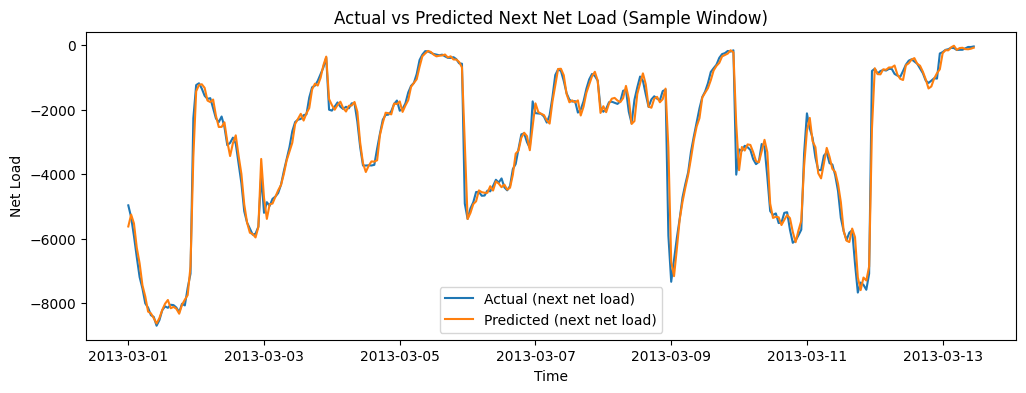

In [16]:
n = 300

plt.figure(figsize=(12,4))
plt.plot(pred_df["timestamp"][:n], pred_df["actual_next_netload"][:n], label="Actual (next net load)")
plt.plot(pred_df["timestamp"][:n], pred_df["pred_next_netload"][:n], label="Predicted (next net load)")
plt.legend()
plt.title("Actual vs Predicted Next Net Load (Sample Window)")
plt.xlabel("Time")
plt.ylabel("Net Load")
plt.show()

In [17]:
sim_df = pd.read_csv("../data_csv/core4_ipynb3_sim_compare.csv")

sim_df

,scenario,peak_exceed,avg_ramp,risky_ramp
0,Reactive (actual trigger),438,232.450071,438
1,Proactive (model trigger),496,233.284130,438


비교 테이블 정리

In [18]:
comparison = sim_df.set_index("scenario")[["peak_exceed", "avg_ramp", "risky_ramp"]].copy()
comparison

,peak_exceed,avg_ramp,risky_ramp
scenario,,,
Reactive (actual trigger),438,232.450071,438
Proactive (model trigger),496,233.284130,438


개선율 계산: 행이 2개 이상일 때, 첫 행을 baseline, 마지막 행을 learned로 가정해서 계산

In [19]:
if comparison.shape[0] >= 2:
    baseline = comparison.iloc[0]
    learned  = comparison.iloc[-1]

    improvement = pd.DataFrame({
        "Metric": comparison.columns,
        "Baseline": baseline.values,
        "Learned": learned.values,
        "Change (%)": (learned.values - baseline.values) / baseline.values * 100
    })
else:
    improvement = pd.DataFrame({"note": ["Not enough scenarios to compute improvement."]})

improvement

,Metric,Baseline,Learned,Change (%)
0,peak_exceed,438.000000,496.00000,13.242009
1,avg_ramp,232.450071,233.28413,0.358812
2,risky_ramp,438.000000,438.00000,0.000000


### 통합 입력 구조

본 Core에서는 부하 및 재생에너지 예측 신호와 함께,  
ESS 제어 결과에서 요약된 통계 지표(방전량, SOC, throughput 등)를 단일 입력 벡터로 통합하였다.

이를 통해 EMS 의사결정이 개별 규칙의 조합이 아니라, 하나의 데이터 기반 함수로 표현 가능한지 검증하였다.

### 결론

부하 및 재생에너지 예측과 ESS 제어 결과를 통합한 단일 ML 모델은  
EMS 의사결정 구조를 데이터 기반으로 구현할 수 있음을 보여준다.  
이는 스마트그리드의 제어가 다수의 규칙 조합이 아니라, 하나의 통합된 의사결정 구조로 표현 가능함을 의미한다.